Day ahead electricity price forecasting with LSTM with 1 week data as input. Train with 1 year of data 2023, and test using 2024 data.

In [1]:
import requests
import pandas as pd

# Define date ranges
# One shot learning
train_start_date = '2023-01-01'
train_end_date = '2024-01-01'
test_start_date = '2024-01-01'
test_end_date = '2024-04-01'

# Fetch data from the API for training and testing
url_train = f"https://api.energy-charts.info/price?bzn=DE-LU&start={train_start_date}&end={train_end_date}"
url_test = f"https://api.energy-charts.info/price?bzn=DE-LU&start={test_start_date}&end={test_end_date}"

response_train = requests.get(url_train)
response_test = requests.get(url_test)

data_train = response_train.json()
data_test = response_test.json()

# Convert to DataFrame
train_df = pd.DataFrame({
    'timestamp': pd.to_datetime(data_train['unix_seconds'], unit='s'),
    'price': data_train['price']
})
test_df = pd.DataFrame({
    'timestamp': pd.to_datetime(data_test['unix_seconds'], unit='s'),
    'price': data_test['price']
})

# Clean the data (remove rows with null prices)
train_df = train_df.dropna()
test_df = test_df.dropna()

# Save DataFrames to CSV
train_df.to_csv('train_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)


In [2]:
import pandas as pd
# Load data from CSV
train_df = pd.read_csv('train_data.csv')
test_df = pd.read_csv('test_data.csv')

# Convert timestamp to datetime format
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])

# Rename columns for NeuralForecast
train_df = train_df.rename(columns={'timestamp': 'ds', 'price': 'y'})
test_df = test_df.rename(columns={'timestamp': 'ds', 'price': 'y'})

# Add unique_id column
train_df['unique_id'] = 'electricity_prices'
test_df['unique_id'] = 'electricity_prices'

# Check date ranges
print("First date in train_df:", train_df['ds'].min())
print("Last date in train_df:", train_df['ds'].max())
print("First date in test_df:", test_df['ds'].min())
print("Last date in test_df:", test_df['ds'].max())

First date in train_df: 2022-12-31 23:00:00
Last date in train_df: 2024-01-01 22:00:00
First date in test_df: 2023-12-31 23:00:00
Last date in test_df: 2024-04-01 21:00:00


Train the Model

In [ ]:
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM

horizon = 24
historical = 24 * 3

model_name = 'LSTM'

# Set up the model with horizon = 24 (for day-ahead hourly forecasts)
models = [
    LSTM(h=horizon,  # Forecast horizon set to 24 to predict the next day's 24 hours
         input_size=historical, # Input size regarding how much info the model gets to forecast the next day
         max_steps=2000,
         scaler_type='standard',
         encoder_n_layers=2,
         encoder_hidden_size=100,
         decoder_hidden_size=512,
         ),
]

# Train the model on the entire training data just once
nf = NeuralForecast(models=models, freq='h')
nf.fit(df=train_df)

Test the model

In [ ]:
# Define the date range based on the test dataset
daterange = pd.date_range(
    start=test_df['ds'].min(),
    end=test_df['ds'].max() - pd.Timedelta(hours=historical),
    freq='24H'
)

# Generate predictions for each 7-day window
predictions = [
    nf.predict(test_df[(test_df['ds'] >= d) & (test_df['ds'] < d + pd.Timedelta(hours=historical))])
    for d in daterange
]

# Flatten the predictions into a DataFrame
forecast_df = pd.concat(predictions, ignore_index=True)

# Ensure the results align with the test dataset
forecast_df = forecast_df[['ds', model_name ]].merge(test_df[['ds', 'y']], on='ds', how='inner')
forecast_df.rename(columns={'y': 'y_actual', model_name: 'y_pred'}, inplace=True)

Plots

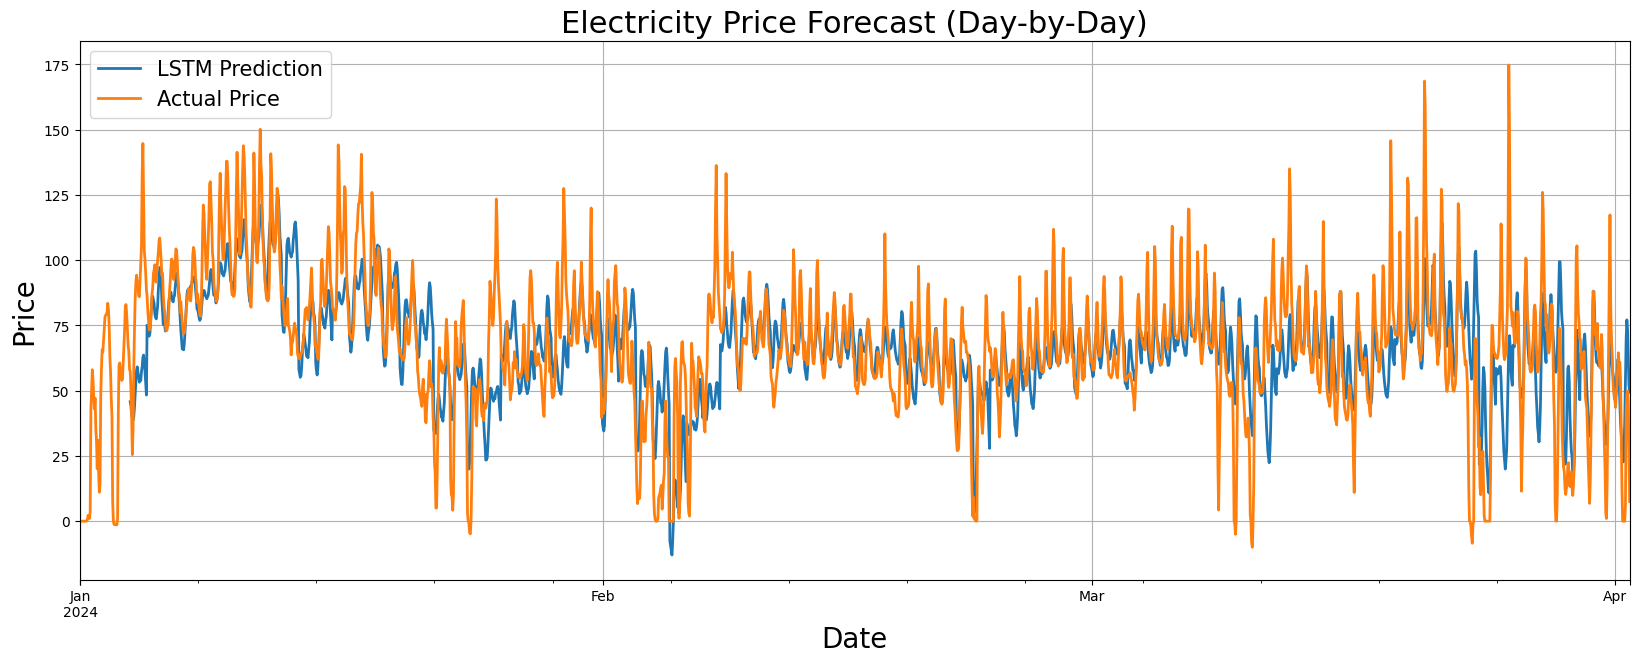

In [5]:
import matplotlib.pyplot as plt

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(20, 7))

# Plot predictions for model
forecast_df.set_index('ds')['y_pred'].plot(ax=ax, linewidth=2, label= f'{model_name} Prediction')

# Optional: Plot actual test values for comparison
test_df.set_index('ds')['y'].plot(ax=ax, linewidth=2, label='Actual Price')

# Formatting the plot
ax.set_title('Electricity Price Forecast (Day-by-Day)', fontsize=22)
ax.set_ylabel('Price', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()
plt.show()

In [6]:
forecast_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2135 entries, 0 to 2134
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ds        2135 non-null   datetime64[ns]
 1   y_pred    2135 non-null   float32       
 2   y_actual  2135 non-null   float64       
dtypes: datetime64[ns](1), float32(1), float64(1)
memory usage: 41.8 KB


In [7]:
forecast_df.head()

,ds,y_pred,y_actual
0,2024-01-03 23:00:00,45.750690,57.30
1,2024-01-04 00:00:00,44.008057,50.46
2,2024-01-04 01:00:00,40.869278,40.00
3,2024-01-04 02:00:00,39.609341,25.48
4,2024-01-04 03:00:00,38.632130,35.00


In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate error metrics
mae = mean_absolute_error(forecast_df['y_actual'], forecast_df['y_pred'])
mse = mean_squared_error(forecast_df['y_actual'], forecast_df['y_pred'])
rmse = np.sqrt(mse)

# Print the results
print("Model Performance:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Model Performance:
Mean Absolute Error (MAE): 13.63
Mean Squared Error (MSE): 361.04
Root Mean Squared Error (RMSE): 19.00


In [9]:
# Merge forecasted values with actual test data, selecting only the relevant columns
comparison_df = forecast_df[['ds', 'y_pred']].merge(test_df[['ds', 'y']], on='ds', how='inner')
comparison_df.rename(columns={'y': 'y_actual', 'y_pred': 'y_pred'}, inplace=True)

# Add a column for the day of the week (0=Monday, 1=Tuesday, ..., 6=Sunday)
comparison_df['day_of_week'] = comparison_df['ds'].dt.dayofweek

# Calculate and display MAE, MSE, and RMSE for each day of the week
metrics_by_day = {}

for day in range(7):
    # Filter data for each day of the week
    day_data = comparison_df[comparison_df['day_of_week'] == day]

    # Calculate the metrics for this day
    mae = mean_absolute_error(day_data['y_actual'], day_data['y_pred'])
    mse = mean_squared_error(day_data['y_actual'], day_data['y_pred'])
    rmse = np.sqrt(mse)

    # Store the metrics for each day
    metrics_by_day[day] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse
    }

    # Print the results for each day
    day_name = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'][day]
    print(f"MAE of {model_name} for {day_name} is: {mae:.2f}")
    print(f"MSE of {model_name} for {day_name} is: {mse:.2f}")
    print(f"RMSE of {model_name} for {day_name} is: {rmse:.2f}")
    print('-' * 50)

# Optionally, you can store these results in a DataFrame for easy viewing or further analysis
metrics_df = pd.DataFrame(metrics_by_day).T
print("\nMetrics by Day of the Week:")
print(metrics_df)

MAE of LSTM for Monday is: 18.36
MSE of LSTM for Monday is: 570.33
RMSE of LSTM for Monday is: 23.88
--------------------------------------------------
MAE of LSTM for Tuesday is: 11.35
MSE of LSTM for Tuesday is: 254.39
RMSE of LSTM for Tuesday is: 15.95
--------------------------------------------------
MAE of LSTM for Wednesday is: 12.74
MSE of LSTM for Wednesday is: 351.69
RMSE of LSTM for Wednesday is: 18.75
--------------------------------------------------
MAE of LSTM for Thursday is: 14.17
MSE of LSTM for Thursday is: 431.43
RMSE of LSTM for Thursday is: 20.77
--------------------------------------------------
MAE of LSTM for Friday is: 11.13
MSE of LSTM for Friday is: 209.72
RMSE of LSTM for Friday is: 14.48
--------------------------------------------------
MAE of LSTM for Saturday is: 13.33
MSE of LSTM for Saturday is: 370.29
RMSE of LSTM for Saturday is: 19.24
--------------------------------------------------
MAE of LSTM for Sunday is: 14.14
MSE of LSTM for Sunday is: 331.

In [10]:
overall_mean = test_df['y'].mean()

# Print the overall mean
print(f"Overall Mean Price: {overall_mean}")

Overall Mean Price: 67.32826008155868


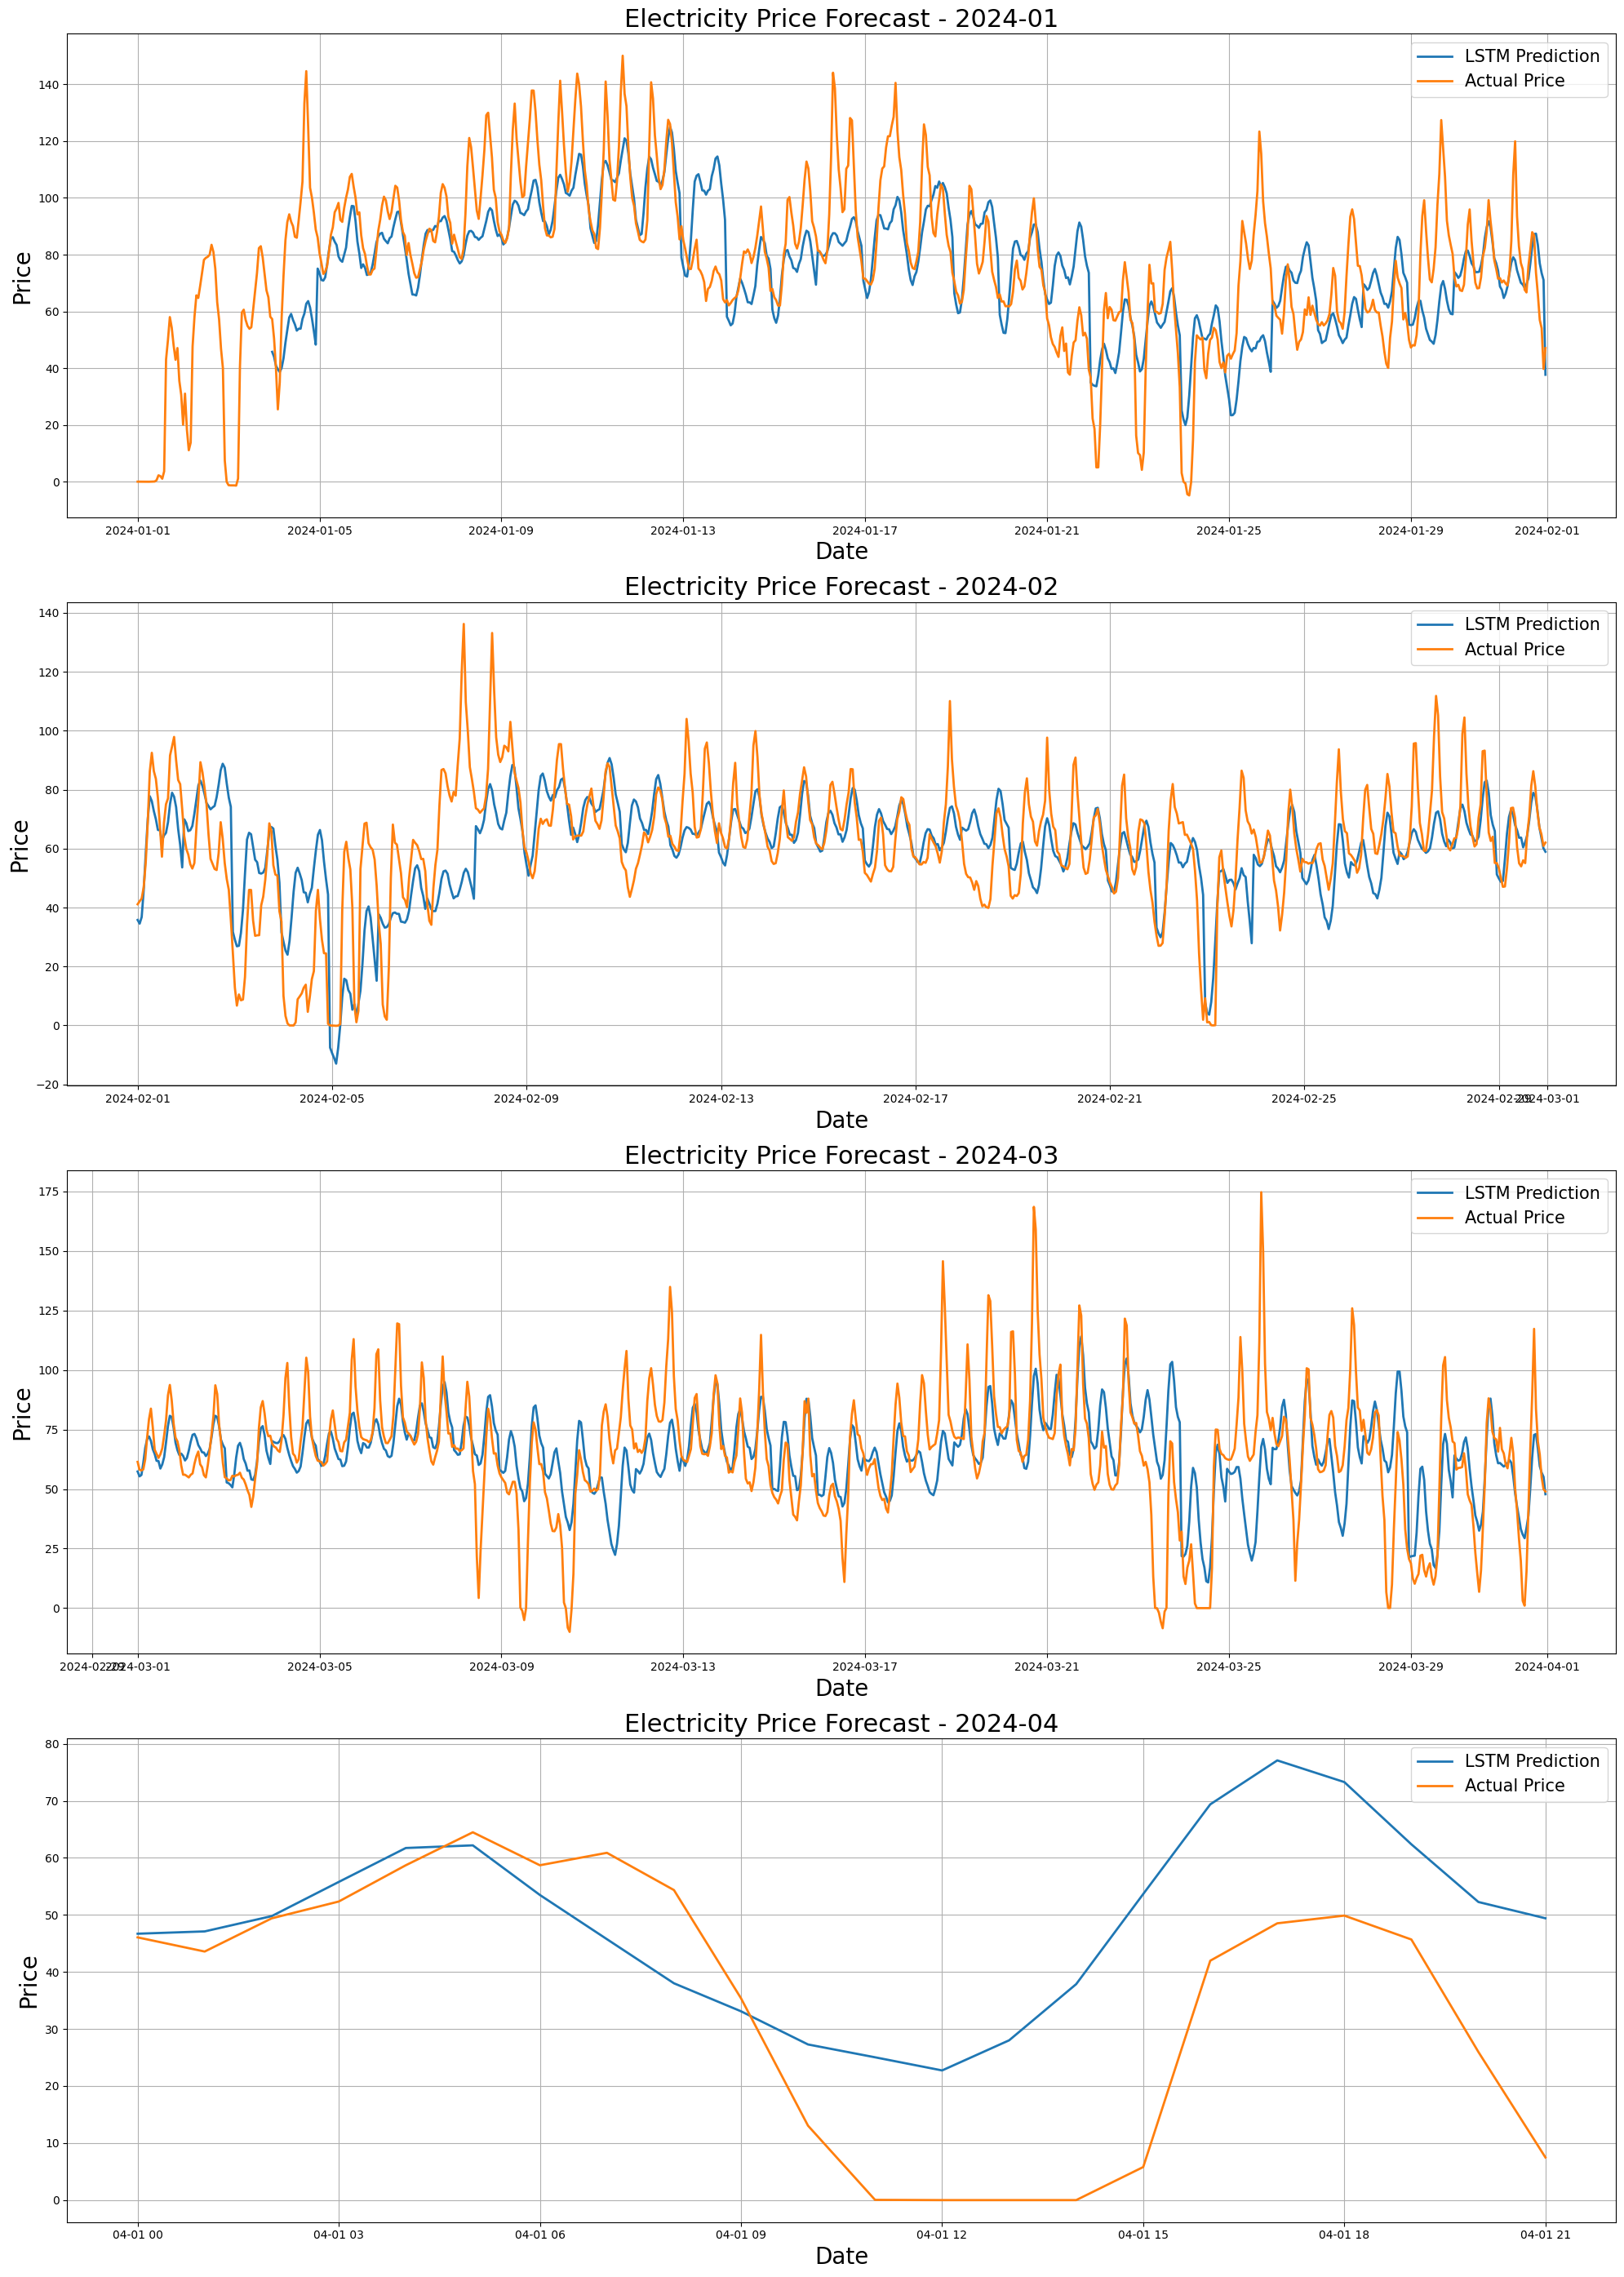

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure 'ds' is in datetime format
forecast_df['ds'] = pd.to_datetime(forecast_df['ds'])
test_df['ds'] = pd.to_datetime(test_df['ds'])

# Create a new figure with multiple subplots, one for each month
unique_months = forecast_df['ds'].dt.to_period('M').unique()

# Set up the figure and axes for plotting
fig, axes = plt.subplots(len(unique_months), 1, figsize=(20, 7 * len(unique_months)))

if len(unique_months) == 1:
    axes = [axes]  # Ensure axes is iterable even if there's only one subplot

for i, month in enumerate(unique_months):
    # Create the data subset for the current month
    month_str = str(month)
    forecast_month = forecast_df[forecast_df['ds'].dt.to_period('M') == month]
    test_month = test_df[test_df['ds'].dt.to_period('M') == month]

    # Plot predictions for the current month
    axes[i].plot(forecast_month['ds'], forecast_month['y_pred'], linewidth=2, label=f'{model_name} Prediction')

    # Plot actual test values for comparison in the current month
    axes[i].plot(test_month['ds'], test_month['y'], linewidth=2, label='Actual Price')

    # Formatting the plot for the current month
    axes[i].set_title(f'Electricity Price Forecast - {month_str}', fontsize=22)
    axes[i].set_ylabel('Price', fontsize=20)
    axes[i].set_xlabel('Date', fontsize=20)
    axes[i].legend(prop={'size': 15})
    axes[i].grid()

# Show the plot
plt.tight_layout()
plt.show()

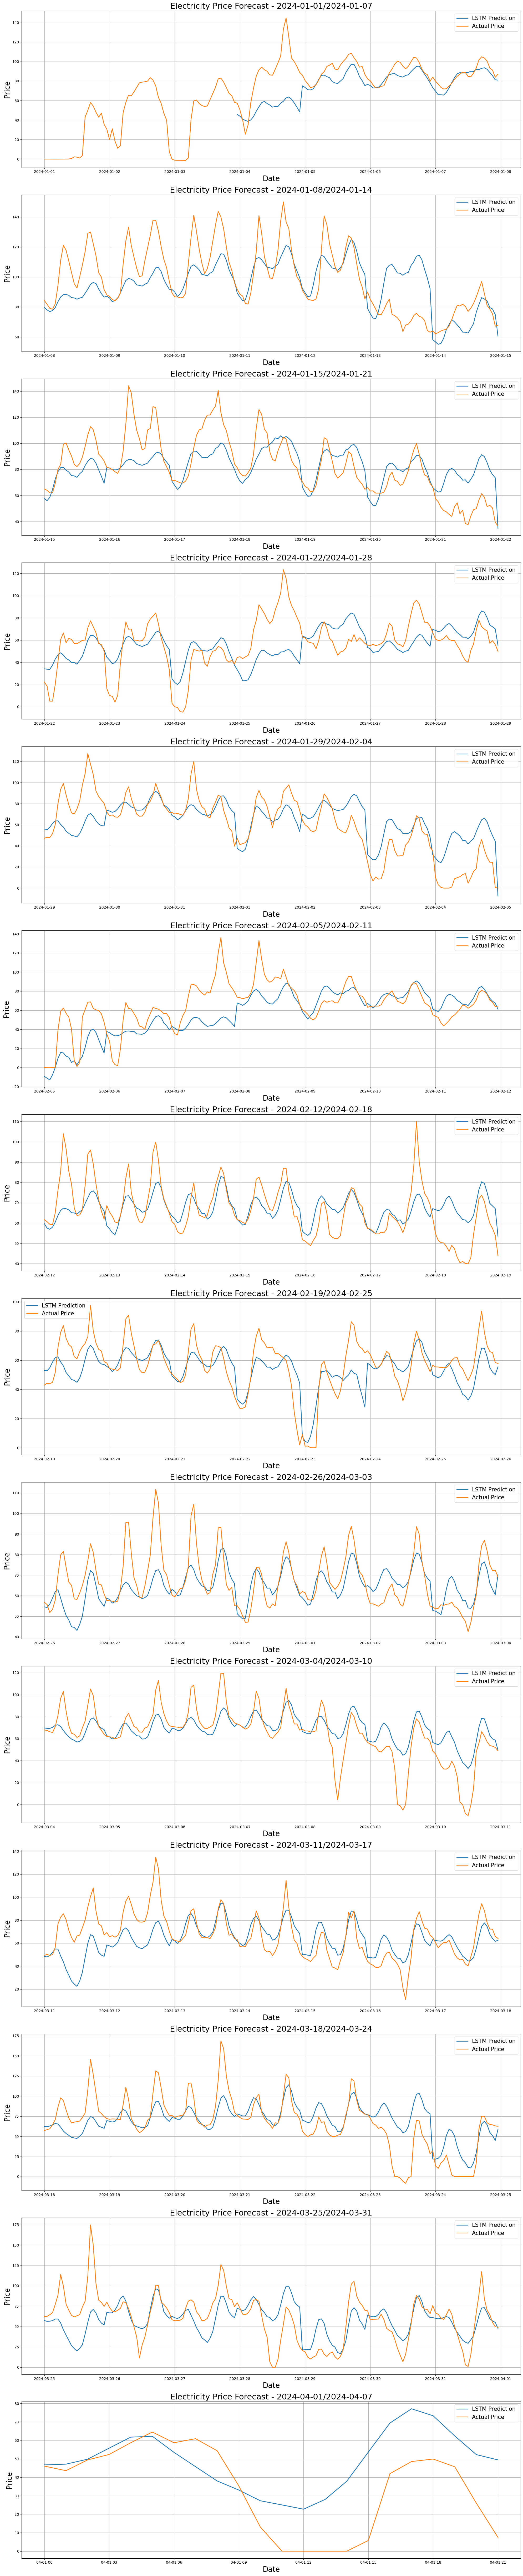

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure 'ds' is in datetime format
forecast_df['ds'] = pd.to_datetime(forecast_df['ds'])
test_df['ds'] = pd.to_datetime(test_df['ds'])

# Create a new figure with multiple subplots, one for each biweekly period
# Group the data by biweekly periods
forecast_df['biweek'] = forecast_df['ds'].dt.to_period('2W')
test_df['biweek'] = test_df['ds'].dt.to_period('2W')

# Get the unique biweekly periods
unique_biweeks = forecast_df['biweek'].unique()

# Set up the figure and axes for plotting
fig, axes = plt.subplots(len(unique_biweeks), 1, figsize=(20, 7 * len(unique_biweeks)))

if len(unique_biweeks) == 1:
    axes = [axes]  # Ensure axes is iterable even if there's only one subplot

for i, biweek in enumerate(unique_biweeks):
    # Create the data subset for the current biweekly period
    biweek_str = str(biweek)
    forecast_biweek = forecast_df[forecast_df['biweek'] == biweek]
    test_biweek = test_df[test_df['biweek'] == biweek]

    # Plot predictions for the current biweekly period
    axes[i].plot(forecast_biweek['ds'], forecast_biweek['y_pred'], linewidth=2, label=f'{model_name} Prediction')

    # Plot actual test values for comparison in the current biweekly period
    axes[i].plot(test_biweek['ds'], test_biweek['y'], linewidth=2, label='Actual Price')

    # Formatting the plot for the current biweekly period
    axes[i].set_title(f'Electricity Price Forecast - {biweek_str}', fontsize=22)
    axes[i].set_ylabel('Price', fontsize=20)
    axes[i].set_xlabel('Date', fontsize=20)
    axes[i].legend(prop={'size': 15})
    axes[i].grid()

# Show the plot
plt.tight_layout()
plt.show()